In [1]:
!pip install albumentations
!pip install transformers
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
/bin/sh: apt: command not found
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import math
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visuals and CV2
import cv2

# albumentations for augs
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold, train_test_split

#torch
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, lr_scheduler

import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from sklearn.model_selection import GroupKFold
%cd '/home/ec2-user/SageMaker/dl-ecommerce-duplicates/'
from modules.datasets.TextTripletLossShopeeDataset import TextTripletLossShopeeDataset
from modules.models.BertWithArcFace import BertWithArcFace
from modules.utils.training_utils import train_triplet_fn,valid_triplet_fn
import faiss
import gc
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.CommonVIsualizer import CommonVisualizer
from modules.losses.TripletLoss import TripletLoss
import os
import torchvision.transforms as transforms
from modules.datasets.ImageTripletLossShopeeDataset import ImageTripletLossShopeeDataset
from torchvision.models import resnet18
import torch.optim as optim
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
from modules.datasets.ImageShopeeDataset import ImageShopeeDataset

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


/home/ec2-user/SageMaker/dl-ecommerce-duplicates


# Configuration

In [3]:
NUM_WORKERS = 4
BATCH_SIZE = 32
EPOCHS = 10
SEED = 2020
LR = 5e-5
thresholds = np.arange(0.4, 0.99, 0.05)
device = torch.device('cuda')

################################################# MODEL ####################################################################

transformer_model = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
TOKENIZER = transformers.AutoTokenizer.from_pretrained(transformer_model)

################################################ Metric Loss and its params #######################################################
loss_module = 'arcface'#'softmax'
s = 30.0
m = 0.5 
ls_eps = 0.0
easy_margin = False

############################################################################################################################
model_params = {
    'n_classes':11014,
    'model_name':transformer_model,
    'pooling':'clf',
    'use_fc':False,
    'fc_dim':512,
    'dropout':0.0,
    'loss_module':loss_module,
    's':30.0,
    'margin':0.50,
    'ls_eps':0.0,
    'theta_zero':0.785,
    'mode_train':True
}
class CFG:
    IMG_SZ = 512
    TRAIN_RATIO = 0.8
    EPOCHS = 10
    MARGIN = 0.75
    


# Some Helper Functions

In [4]:
def read_dataset(file):
    df = pd.read_csv(file)
    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['target'] = df['label_group'].map(tmp)
    df['target'] = df['target'].apply(lambda x: ' '.join(x))
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    df['target'] = df['label_group'].map(grouped)
    return df

In [5]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    # Create an empty DataFrame with the desired column names
    train_loss_df = pd.DataFrame(columns=['Epoch', 'Train_Loss'])
    valid_loss_df = pd.DataFrame(columns=['Epoch', 'Valid_Loss'])
    
    # THE ENGINE LOOP
    # best_loss = 10000
    for epoch in range(epoch):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            anchor, positive, negative, target = data
            anchor, positive, negative, target = anchor.to(device), positive.to(device), negative.to(device), target.to(device)
            optimizer.zero_grad()
            anchor = model(anchor)
            positive = model(positive)
            negative = model(negative)
            loss = criterion(anchor, positive, negative)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))

        ## Validation
        val_loss = 0.0
        model.eval()
        valid_enumerator = enumerate(valid_loader, 0)
        for i, data in valid_enumerator:
            with torch.no_grad():
                anchor, positive, negative, target = data
                anchor, positive, negative, target = anchor.to(device), positive.to(device), negative.to(device), target.to(device)
                optimizer.zero_grad()
                anchor = model(anchor)
                positive = model(positive)
                negative = model(negative)
                loss = criterion(anchor, positive, negative)
                val_loss += loss.cpu().numpy()

        # Append a row to the DataFrame with the epoch number and loss]
        train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss}, ignore_index=True)
        valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': val_loss}, ignore_index=True)

        torch.save(model.state_dict(), f'results/resnet_triplet_epoch_{epoch}.bin')
    
    return model, train_loss_df,valid_loss_df

# TRAIN

In [6]:
def append_string(df,image,anchor,positive,negative):
    append_string = "../shopee-product-matching/train_images/"
    df[image] = append_string + df[image]
    df[anchor] = append_string + df[anchor]
    df[positive] = append_string + df[positive]
    df[negative] = append_string + df[negative]
    return df
    

In [7]:
#Training Data Set
file = '../shopee-product-matching/image_triplets/train80.csv'
train_df = read_dataset(file)
train_df = append_string(train_df,'image','anchor','positive','negative')
train_df['label_group'] = LabelEncoder().fit_transform(train_df['label_group'])

#Validation Dataset
file = '../shopee-product-matching/image_triplets/valid20.csv'
valid_df = read_dataset(file)
valid_df = append_string(valid_df,'image','anchor','positive','negative')
valid_df['label_group'] = LabelEncoder().fit_transform(valid_df['label_group'])

#Full Dataset
file = '../shopee-product-matching/image_triplets/train_triplets_images.csv'
full_df = read_dataset(file)
full_df = append_string(full_df,'image','anchor','positive','negative')
full_df['label_group'] = LabelEncoder().fit_transform(full_df['label_group'])

In [8]:
# train_df = train_df.head(10000)
# valid_df = valid_df.head(1000)

In [8]:
train_transforms = transforms.Compose([
        transforms.Resize((CFG.IMG_SZ, CFG.IMG_SZ)),
        transforms.RandomPosterize(bits=2, p=0.3),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomAutocontrast(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize((CFG.IMG_SZ, CFG.IMG_SZ)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = ImageTripletLossShopeeDataset(
    train_df['anchor'].values,
    train_df['positive'].values,
    train_df['negative'].values,
    train_df['label_group'].values,
    train_transforms,
)

valid_dataset = ImageTripletLossShopeeDataset(
    valid_df['anchor'].values,
    valid_df['positive'].values,
    valid_df['negative'].values,
    valid_df['label_group'].values,
    valid_transforms,
)


#Batch train loder
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=True,
    num_workers=NUM_WORKERS
)

#Batch train loder
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=True,
    num_workers=NUM_WORKERS
)

In [9]:
EPOCHS = 5
model_name = 'resnet_triplet_10_epochs'
model_params['loss_module'] = "triplet"
train_loss_file = os.path.join('results/', model_name + '_train_loss.csv')
valid_loss_file = os.path.join('results/', model_name + '_valid_loss.csv')
model_file = os.path.join('results/', model_name + '.bin')
# Define the model
model = ResNet18EmbeddingsShopeeNet()
# model.fc = nn.Linear(512, 128, bias=True)
model = model.to(device)
# Define the loss function and optimizer
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model, train_loss_df, valid_loss_df = train(model, train_loader, optimizer, criterion, EPOCHS, device)
torch.save(model.state_dict(), model_file)
train_loss_df.to_csv(train_loss_file)
valid_loss_df.to_csv(valid_loss_file)

Train Epoch: 0 [0/27399 (0%)]	Loss: 7.335422
Train Epoch: 0 [400/27399 (12%)]	Loss: 0.966087
Train Epoch: 0 [800/27399 (23%)]	Loss: 1.068487
Train Epoch: 0 [1200/27399 (35%)]	Loss: 0.931978
Train Epoch: 0 [1600/27399 (47%)]	Loss: 0.950140
Train Epoch: 0 [2000/27399 (58%)]	Loss: 1.053231
Train Epoch: 0 [2400/27399 (70%)]	Loss: 0.990470
Train Epoch: 0 [2800/27399 (82%)]	Loss: 1.019809
Train Epoch: 0 [3200/27399 (93%)]	Loss: 0.995268
====> Epoch: 0 Average loss: 0.0368


/tmp/ipykernel_25872/1416028851.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss}, ignore_index=True)
/tmp/ipykernel_25872/1416028851.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': val_loss}, ignore_index=True)


Train Epoch: 1 [0/27399 (0%)]	Loss: 1.006023
Train Epoch: 1 [400/27399 (12%)]	Loss: 0.994645
Train Epoch: 1 [800/27399 (23%)]	Loss: 1.008831
Train Epoch: 1 [1200/27399 (35%)]	Loss: 0.989296
Train Epoch: 1 [1600/27399 (47%)]	Loss: 1.002705
Train Epoch: 1 [2000/27399 (58%)]	Loss: 0.932815
Train Epoch: 1 [2400/27399 (70%)]	Loss: 1.008507
Train Epoch: 1 [2800/27399 (82%)]	Loss: 1.002258
Train Epoch: 1 [3200/27399 (93%)]	Loss: 1.000372
====> Epoch: 1 Average loss: 0.0313


/tmp/ipykernel_25872/1416028851.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss}, ignore_index=True)
/tmp/ipykernel_25872/1416028851.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': val_loss}, ignore_index=True)


Train Epoch: 2 [0/27399 (0%)]	Loss: 1.002653
Train Epoch: 2 [400/27399 (12%)]	Loss: 1.039613
Train Epoch: 2 [800/27399 (23%)]	Loss: 0.996655
Train Epoch: 2 [1200/27399 (35%)]	Loss: 0.997976
Train Epoch: 2 [1600/27399 (47%)]	Loss: 0.993687
Train Epoch: 2 [2000/27399 (58%)]	Loss: 1.002211
Train Epoch: 2 [2400/27399 (70%)]	Loss: 1.029529
Train Epoch: 2 [2800/27399 (82%)]	Loss: 1.011267
Train Epoch: 2 [3200/27399 (93%)]	Loss: 1.025573
====> Epoch: 2 Average loss: 0.0313


/tmp/ipykernel_25872/1416028851.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss}, ignore_index=True)
/tmp/ipykernel_25872/1416028851.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': val_loss}, ignore_index=True)


Train Epoch: 3 [0/27399 (0%)]	Loss: 1.007714
Train Epoch: 3 [400/27399 (12%)]	Loss: 0.982758
Train Epoch: 3 [800/27399 (23%)]	Loss: 0.991456
Train Epoch: 3 [1200/27399 (35%)]	Loss: 0.996561
Train Epoch: 3 [1600/27399 (47%)]	Loss: 0.992286
Train Epoch: 3 [2000/27399 (58%)]	Loss: 0.984592
Train Epoch: 3 [2400/27399 (70%)]	Loss: 1.006083
Train Epoch: 3 [2800/27399 (82%)]	Loss: 1.001042
Train Epoch: 3 [3200/27399 (93%)]	Loss: 0.996883
====> Epoch: 3 Average loss: 0.0313


/tmp/ipykernel_25872/1416028851.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss}, ignore_index=True)
/tmp/ipykernel_25872/1416028851.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': val_loss}, ignore_index=True)


Train Epoch: 4 [0/27399 (0%)]	Loss: 1.005681
Train Epoch: 4 [400/27399 (12%)]	Loss: 1.000081
Train Epoch: 4 [800/27399 (23%)]	Loss: 1.004208
Train Epoch: 4 [1200/27399 (35%)]	Loss: 1.000890
Train Epoch: 4 [1600/27399 (47%)]	Loss: 0.999856
Train Epoch: 4 [2000/27399 (58%)]	Loss: 1.000956
Train Epoch: 4 [2400/27399 (70%)]	Loss: 1.001822
Train Epoch: 4 [2800/27399 (82%)]	Loss: 0.999591
Train Epoch: 4 [3200/27399 (93%)]	Loss: 0.999686
====> Epoch: 4 Average loss: 0.0313


/tmp/ipykernel_25872/1416028851.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss}, ignore_index=True)
/tmp/ipykernel_25872/1416028851.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': val_loss}, ignore_index=True)


In [10]:
# Validating on Train, Validation and Full Dataset

In [12]:
valid_transforms = transforms.Compose([
        transforms.Resize((CFG.IMG_SZ, CFG.IMG_SZ)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = ImageShopeeDataset(
    train_df['image'].values,
    valid_transforms,
)

valid_dataset = ImageShopeeDataset(
    valid_df['image'].values,
    valid_transforms,
)

full_dataset = ImageShopeeDataset(
    full_df['image'].values,
    valid_transforms,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

full_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)



100%|██████████| 12/12 [00:34<00:00,  2.83s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


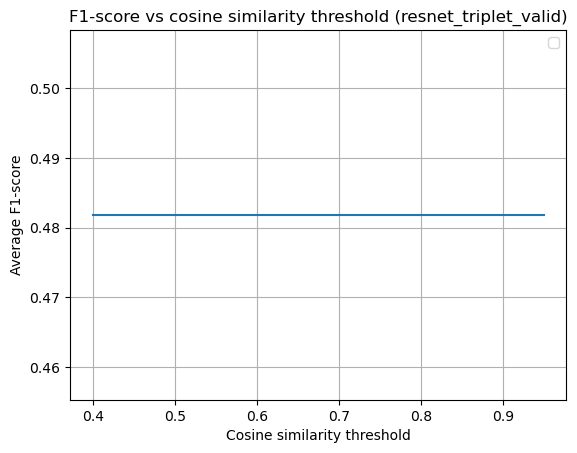

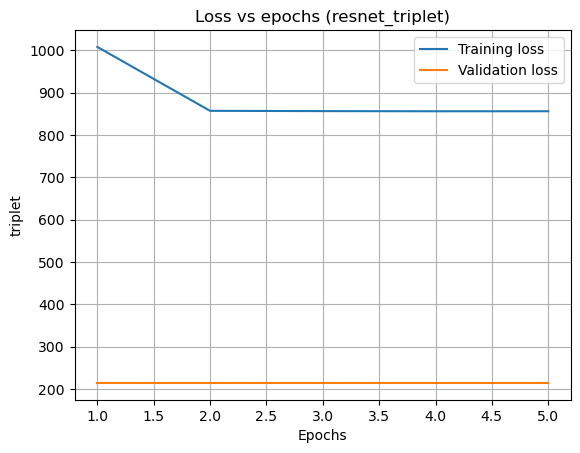

Max f1 score 0.48183698288337734


In [26]:
model_name_val = "resnet_triplet"
producer = EmbeddingsProducer(model, device)
embeddings = producer.get_embeddings(valid_loader, normalize=True)
embeddings = embeddings.squeeze()
f1_avg_scores = F1ScoreEvaluator(valid_df,embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
f1_avg_scores = [val*10 for val in f1_avg_scores]
model_name_and_loss = model_name_val + "_valid"
filename = os.path.join('results/', model_name_and_loss) 
model_name_and_loss = model_name_val + "_valid"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
filename = os.path.join('results/', model_name_val + '_train_and_valid_loss') 
train_loss_df = pd.read_csv(train_loss_file)
valid_loss_df = pd.read_csv(valid_loss_file)
CommonVisualizer().plt_losses( train_loss_df.Train_Loss.values, valid_loss_df.Valid_Loss.values, model_name_val, model_params['loss_module'], filename)
print("Max f1 score",np.max(f1_avg_scores))

100%|██████████| 12/12 [02:37<00:00, 13.09s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


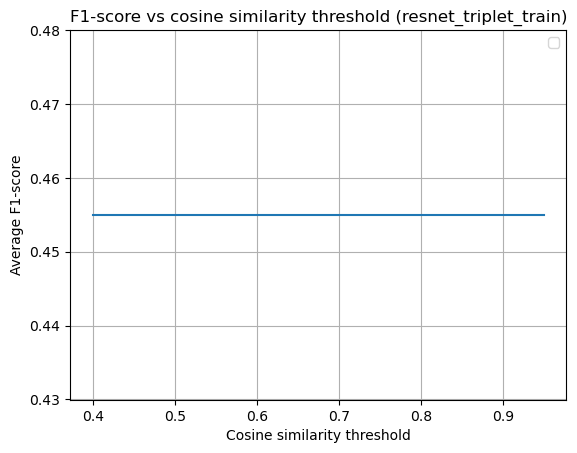

Max f1 score 0.45497843642900543


In [27]:
producer = EmbeddingsProducer(model, device)
embeddings = producer.get_embeddings(train_loader, normalize=True)
embeddings = embeddings.squeeze()
f1_avg_scores = F1ScoreEvaluator(train_df,embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
model_name_and_loss = model_name_val + "_train"
filename = os.path.join('results/', model_name_and_loss) 
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max f1 score",np.max(f1_avg_scores))

100%|██████████| 12/12 [03:23<00:00, 16.98s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


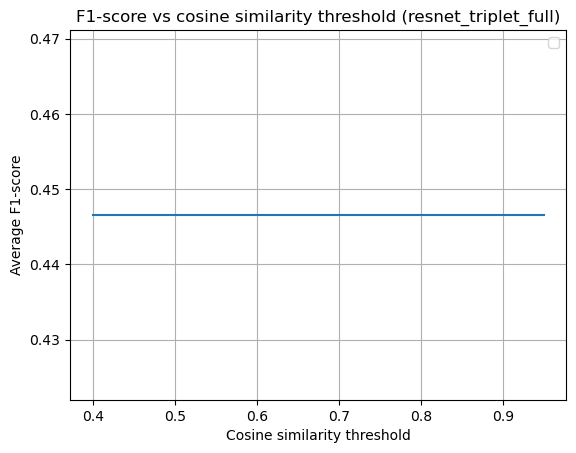

Max f1 score 0.44655940997145366


In [ ]:
producer = EmbeddingsProducer(model, device)
embeddings = producer.get_embeddings(full_loader, normalize=True)
embeddings = embeddings.squeeze()
f1_avg_scores = F1ScoreEvaluator(full_df,embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
model_name_and_loss = model_name_val + "_full"
filename = os.path.join('results/', model_name_and_loss) 
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max f1 score",np.max(f1_avg_scores))